In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
REBUILD_DATA = True

In [3]:
class DogsVsCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat/"
    DOGS = "PetImages/Dog/"
    LABELS = {CATS:0,DOGS:1}
    training_data = []
    catcount = -1
    dogcount = -1
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    f = str(label) + str(f)
                    img = cv2.imread(f,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save('training_data.npy',self.training_data)
        print(self.catcount)
        print(self.dogcount)

In [4]:
if REBUILD_DATA:
    dvc = DogsVsCats()
    dvc.make_training_data()

  1%|          | 142/12501 [00:00<00:08, 1410.00it/s]

PetImages/Cat/


  1%|          | 148/12501 [00:00<00:08, 1473.43it/s]

PetImages/Dog/


100%|██████████| 12501/12501 [00:08<00:00, 1395.69it/s]
/home/indika/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


12475
12469


In [5]:
training_data = np.load('training_data.npy',allow_pickle=True)

In [6]:
len(training_data)

24946

In [7]:
print(training_data[0][0])

[[ 71  63  41 ... 207 219 227]
 [ 60  39  71 ... 208 222 228]
 [ 77  49  58 ... 208 222 227]
 ...
 [ 93  92 104 ...  99  93  81]
 [104 106 108 ...  84  74  63]
 [106 102  97 ...  70  65  63]]


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

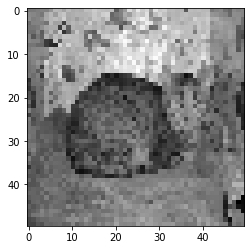

In [9]:
plt.imshow(training_data[1][0]/255.0,cmap='gray')
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# https://www.coinmama.com/
# https://cex.io/
# https://www.coinfield.com/

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 64, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(64, 128, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(128, 256, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        print(x.shape)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 1024) #flattening.
        self.fc2 = nn.Linear(1024, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

torch.Size([1, 1, 50, 50])
Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [13]:
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_funtion = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
VAL_PCT = 0.25
VAL_SIZE = int(len(X)*VAL_PCT)

In [14]:
train_X = X[:-VAL_SIZE]
train_y = y[:-VAL_SIZE]
test_X = X[-VAL_SIZE:]
test_y = y[-VAL_SIZE:]

In [15]:
print(len(test_X))

6236


In [16]:
print(len(train_X))

18710


In [17]:
BATCH_SIZE = 32

In [18]:
# EPOCHS = 250
# for epoch in tqdm(range(EPOCHS)):
#     for i in range(0,len(train_X),BATCH_SIZE):
#         batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
#         batch_y = train_y[i:i+BATCH_SIZE]
#         net.zero_grad()
#         outputs = net(batch_X)
#         loss = loss_funtion(outputs,batch_y)
#         loss.backward()
#         optimizer.step()
# print(loss)

In [19]:
# correct = 0
# total = 0
# net.eval()
# with torch.no_grad():
#     for i in tqdm(range(len(test_X))):
#         real_class = torch.argmax(test_y[i])
# #         print(real_class)
#         net_out = net(test_X[i].view(-1,1,50,50))
# #         print(net_out)
#         net_out = net_out[0]
#         predictied_class = torch.argmax(net_out)
#         if predictied_class == real_class:
#             correct += 1
#         total += 1
# print(round(correct/total,3))

In [20]:
torch.cuda.is_available()

True

In [21]:
!nvidia-smi

Mon May 17 15:46:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3060    Off  | 00000000:26:00.0  On |                  N/A |
| 64%   50C    P8    13W / 170W |    338MiB / 12045MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
device

device(type='cuda', index=0)

In [24]:
torch.cuda.device_count()

1

In [25]:
# net.to(device)

In [26]:
net = Net().to(device)

torch.Size([1, 1, 50, 50])


In [ ]:
EPOCHS = 250

In [ ]:
def train(net):
    optimizer = optim.Adam(net.parameters(),lr=0.001)
    loss_funtion = nn.MSELoss()
    for epoch in tqdm(range(EPOCHS)):
        for i in range(0,len(train_X),BATCH_SIZE):
#         print(i,i+BATCH_SIZE)
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]
            batch_X,batch_y = batch_X.to(device),batch_y.to(device)
            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_funtion(outputs,batch_y)
            loss.backward()
            optimizer.step()
#         print(f'Epoch : {epoch}/{EPOCHS}, Loss : {loss.item()}')
    print(batch_X.shape)
    print(batch_y.shape)
    return outputs

In [ ]:
train(net).shape

100%|██████████| 250/250 [12:58<00:00,  3.12s/it]

torch.Size([22, 1, 50, 50])
torch.Size([22, 2])


torch.Size([22, 2])

In [ ]:
# CPU = 07:53
# GPU = 00:43

In [ ]:
def test(net):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1,1,50,50).to(device))
            net_out = net_out[0]
            predictied_class = torch.argmax(net_out)
            if predictied_class == real_class:
                correct += 1
            total += 1
    print(round(correct/total,3))

In [ ]:
test(net)

100%|██████████| 6236/6236 [00:03<00:00, 1621.86it/s]

0.613


In [ ]:
train(net)

100%|██████████| 250/250 [13:05<00:00,  3.14s/it]

torch.Size([22, 1, 50, 50])
torch.Size([22, 2])


tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
test(net)

100%|██████████| 6236/6236 [00:04<00:00, 1543.80it/s]

0.501


In [ ]:
train(net)

  7%|▋         | 17/250 [00:54<12:24,  3.20s/it]

In [ ]:
test(net)

In [ ]:
def fwd_pass(X,y,train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
        